In [1]:
import os

from monai.losses import DiceLoss
from monai.losses import FocalLoss
from torch_lr_finder import LRFinder
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import torch
import torchvision
from torchvision.io import read_image
from torchvision.transforms import Pad
import torchvision.transforms as transforms
from torchvision.datasets import VisionDataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Пк\.cache\kagglehub\datasets\balraj98\massachusetts-roads-dataset\versions\1


In [3]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.conv = nn.Sequential(
                                  nn.Conv2d(ch_in, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(ch_out, ch_out,
                                            kernel_size=3, stride=1,
                                            padding=1, bias=True),
                                  nn.BatchNorm2d(ch_out),
                                  nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = self.conv(x)
        return x

In [5]:
class UpConvBlock(nn.Module):
    def __init__(self, ch_in, ch_out):
        super().__init__()
        self.up = nn.Sequential(
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(ch_in, ch_out,
                                         kernel_size=3,stride=1,
                                         padding=1, bias=True),
                                nn.BatchNorm2d(ch_out),
                                nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        x = x = self.up(x)
        return x

In [6]:
class AttentionUNet(nn.Module):
    def __init__(self, n_classes=1, in_channel=3, out_channel=1):
        super().__init__() 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.3, inplace=True)
        
        self.conv1 = ConvBlock(ch_in=in_channel, ch_out=64)
        self.conv2 = ConvBlock(ch_in=64, ch_out=128)
        self.conv3 = ConvBlock(ch_in=128, ch_out=256)
        self.conv4 = ConvBlock(ch_in=256, ch_out=512)
        self.conv5 = ConvBlock(ch_in=512, ch_out=1024)
        
        self.up5 = UpConvBlock(ch_in=1024, ch_out=512)
        self.att5 = AttentionBlock(f_g=512, f_l=512, f_int=256)
        self.upconv5 = ConvBlock(ch_in=1024, ch_out=512)
        
        self.up4 = UpConvBlock(ch_in=512, ch_out=256)
        self.att4 = AttentionBlock(f_g=256, f_l=256, f_int=128)
        self.upconv4 = ConvBlock(ch_in=512, ch_out=256)
        
        self.up3 = UpConvBlock(ch_in=256, ch_out=128)
        self.att3 = AttentionBlock(f_g=128, f_l=128, f_int=64)
        self.upconv3 = ConvBlock(ch_in=256, ch_out=128)
        
        self.up2 = UpConvBlock(ch_in=128, ch_out=64)
        self.att2 = AttentionBlock(f_g=64, f_l=64, f_int=32)
        self.upconv2 = ConvBlock(ch_in=128, ch_out=64)
        
        self.conv_1x1 = nn.Conv2d(64, out_channel,
                                  kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        
        x2 = self.maxpool(x1)
        x2 = self.dropout(x2)
        x2 = self.conv2(x2)
        
        x3 = self.maxpool(x2)
        x3 = self.dropout(x3)
        x3 = self.conv3(x3)
        
        x4 = self.maxpool(x3)
        x4 = self.dropout(x4)
        x4 = self.conv4(x4)
        
        x5 = self.maxpool(x4)
        x5 = self.dropout(x5)
        x5 = self.conv5(x5)
        
        # decoder + concat
        d5 = self.up5(x5)
        x4 = self.att5(g=d5, x=x4)
        d5 = torch.concat((x4, d5), dim=1)
        d5 = self.upconv5(d5)
        
        d4 = self.up4(d5)
        x3 = self.att4(g=d4, x=x3)
        d4 = torch.concat((x3, d4), dim=1)
        d4 = self.dropout(d4)
        d4 = self.upconv4(d4)
        
        d3 = self.up3(d4)
        x2 = self.att3(g=d3, x=x2)
        d3 = torch.concat((x2, d3), dim=1)
        d3 = self.dropout(d3)
        d3 = self.upconv3(d3)
        
        d2 = self.up2(d3)
        x1 = self.att2(g=d2, x=x1) 
        d2 = torch.concat((x1, d2), dim=1)
        d2 = self.dropout(d2)
        d2 = self.upconv2(d2)
        
        d1 = self.conv_1x1(d2)
        return torch.sigmoid(d1)

In [8]:
part = 1
class seg_dataset(VisionDataset):
    def __init__(self, image_root, label_root, image_transform=None, label_transform=None,pair_transform=None,RAM=False):
        #super().__init__(image_root, transform=transform)
        self.RAM = RAM
        self.image_root = image_root
        self.label_root = label_root
        self.image_transforms = (image_transform != None)
        self.label_transforms = (label_transform != None)
        self.pair_transforms = (pair_transform != None)
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.pair_transform = pair_transform
        self.image_names = os.listdir(image_root)
        self.label_names = os.listdir(label_root)
        self.image_names = self.image_names[:(int(len(self.image_names)*part))]
        self.label_names = self.label_names[:(int(len(self.label_names)*part))]
        if self.RAM:
            self.items = []
            for i in tqdm(range(len(self.image_names))):
                image_path = os.path.join(self.image_root, self.image_names[i])
                label_path = os.path.join(self.label_root, self.label_names[i])
                img = Image.open(image_path).convert('RGB')
                label = Image.open(label_path)
                if self.pair_transforms:
                    img, label = self.pair_transform(img,label)
                else:
                    if self.image_transforms:
                        img = self.image_transform(img)
                    if self.label_transforms:
                        label = self.label_transform(label)
                self.items.append((img,label))

    def __getitem__(self, index):
        image_path = os.path.join(self.image_root, self.image_names[index])
        label_path = os.path.join(self.label_root, self.label_names[index])
        img = Image.open(image_path).convert('RGB')
        label = Image.open(label_path)
        if self.RAM:
            return self.items[index]
        if self.pair_transforms:
            img, label = self.pair_transform(img,label)
        else:
            if self.image_transforms:
                img = self.image_transform(img)
            if self.label_transforms:
                label = self.label_transform(label)
        return (img,label) 

    def __len__(self):
        return len(self.image_names)

In [9]:
class ConditionalResize:
    def __init__(self):
        return

    def __call__(self, image):
        img = image
        if img.shape[1] % 2 != 0:
            img = Pad((0,0,0,1))(img)
        if img.shape[2] % 2 != 0:
            img = Pad((0,0,1,0))(img)
        return img

In [10]:
class WhereTransform:
    def __init__(self):
        return

    def __call__(self, tensor):
        return torch.where(tensor > 0, 1, 0).float()

In [11]:
imsize = 512
train_no_aug_transform = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    ConditionalResize()
])
label_transform = transforms.Compose([
    transforms.Resize(1024),
    transforms.ToTensor(),
    ConditionalResize(),
    WhereTransform()
])
val_transform = transforms.Compose([
    transforms.Resize(1024),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    ConditionalResize()
])

In [12]:
class PairTransform:
    def __init__(self):
        global imsize
        self.train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop(imsize),
            #transforms.Resize(imsize),
            transforms.RandomRotation(degrees=45,expand=False),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5),
            #transforms.RandomErasing(p=0.5, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=True),
            ConditionalResize()
        ])
        self.label = transforms.Compose([
            transforms.RandomHorizontalFlip(), 
            transforms.RandomVerticalFlip(),
            transforms.RandomCrop(imsize),
            #transforms.Resize(imsize),
            transforms.RandomRotation(degrees=45,expand=False),
            transforms.ToTensor(),
            #transforms.RandomErasing(p=0.5, scale=(0.2, 0.2), ratio=(1, 1), value=0, inplace=True),
            ConditionalResize()
        ])

    def __call__(self, img, mask):
        seed = torch.randint(0, 100000, (1,)).item()
        torch.manual_seed(seed)
        img = self.train(img)
        torch.manual_seed(seed)
        mask = self.label(mask)
        return img, mask


In [13]:
train_dataset = seg_dataset(
    image_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/train', 
    label_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/train_labels',
    image_transform = train_no_aug_transform,
    label_transform = label_transform
)
validation_dataset = seg_dataset(
    image_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/val',
    label_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/val_labels',
    image_transform = val_transform,
    label_transform = label_transform
)

In [14]:
batch_size = 4
train_aug_dataset = seg_dataset(
            image_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/train', 
            label_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/train_labels',
            pair_transform = PairTransform(),
            RAM = False
            )
train_loader = torch.utils.data.DataLoader(train_aug_dataset, batch_size=batch_size, shuffle=True, num_workers=0,pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=False, num_workers=0)

In [16]:
def show_pair(pair):
    img = pair[0]
    label = pair[1]
    img = OneToFour(img)
    output = riba.forward(img.cuda())
    output = FourToOne(output)
    plt.figure(figsize=(6, 3))  # Adjust figure size as needed
    plt.subplot(1, 2, 1)  # (rows, columns, index)
    plt.imshow(output.detach().cpu().reshape(1024,1024,1).numpy(),cmap='gray')  # Use cmap='gray' for grayscale
    plt.title("model output")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(label.reshape(1024,1024,1).numpy(), cmap='gray')
    plt.title("ground truth")
    plt.axis('off')
    return plt.show()

In [17]:
class CombinedLoss:
    def __init__(self):
        self.dice = DiceLoss().cuda()
        self.focal = FocalLoss().cuda()
    def __call__(self,output,target):
        return self.dice(output,target) + self.focal(output,target)

In [18]:
def OneToFour(img):
    hor = torch.split(img,imsize,dim=2)
    pics = []
    pics.extend(torch.split(hor[0],imsize,dim=3))
    pics.extend(torch.split(hor[1],imsize,dim=3))
    return torch.stack(pics,dim=1).squeeze(0)

In [19]:
def FourToOne(imgs):
    ver1 = torch.concat((imgs[0],imgs[1]),dim=2)
    ver2 = torch.concat((imgs[2],imgs[3]),dim=2)
    return torch.concat((ver1,ver2),dim=1).unsqueeze(0)

In [20]:
riba = AttentionUNet().cuda()
loss_function = CombinedLoss()
optim = torch.optim.Adam(riba.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,patience=3,factor=0.1,threshold=0.001,mode='min')

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [05:40<00:00,  1.23s/it]


epoch 0 | loss 0.28790 | average IoU for validation 29.03% | validation loss 0.9327 | learning rate 0.0001


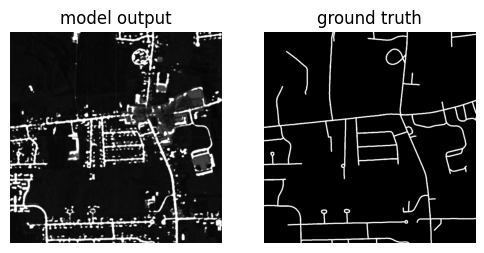

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:35<00:00,  1.01it/s]


epoch 1 | loss 0.26212 | average IoU for validation 37.13% | validation loss 0.8288 | learning rate 0.0001


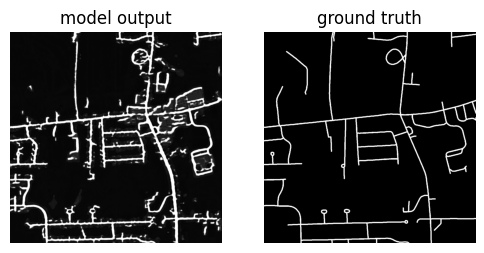

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:28<00:00,  1.03it/s]


epoch 2 | loss 0.23544 | average IoU for validation 46.54% | validation loss 0.6583 | learning rate 0.0001


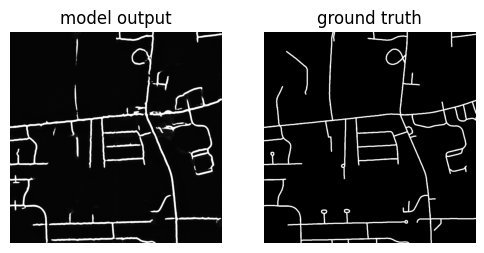

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:27<00:00,  1.04it/s]


epoch 3 | loss 0.21432 | average IoU for validation 42.23% | validation loss 0.6626 | learning rate 0.0001


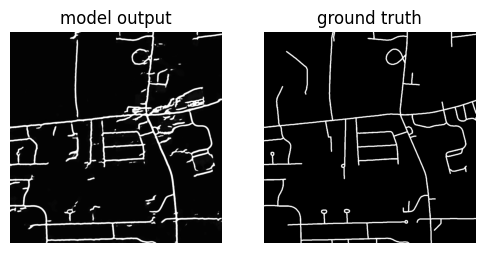

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:25<00:00,  1.04it/s]


epoch 4 | loss 0.19948 | average IoU for validation 51.92% | validation loss 0.5438 | learning rate 0.0001


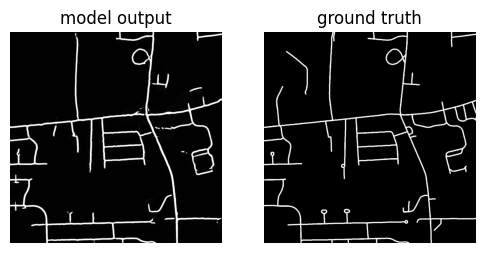

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:20<00:00,  1.06it/s]


epoch 5 | loss 0.19164 | average IoU for validation 50.97% | validation loss 0.5326 | learning rate 0.0001


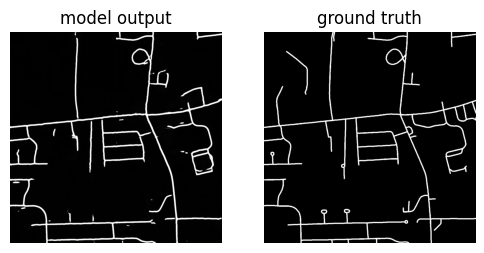

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:30<00:00,  1.02it/s]


epoch 6 | loss 0.18437 | average IoU for validation 51.95% | validation loss 0.5156 | learning rate 0.0001


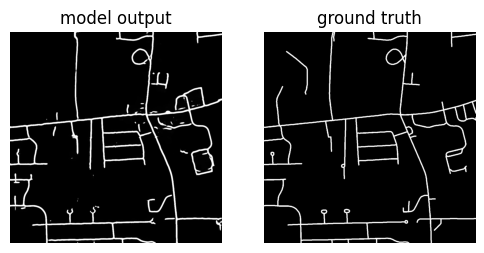

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:20<00:00,  1.07it/s]


epoch 7 | loss 0.18281 | average IoU for validation 53.74% | validation loss 0.4952 | learning rate 0.0001


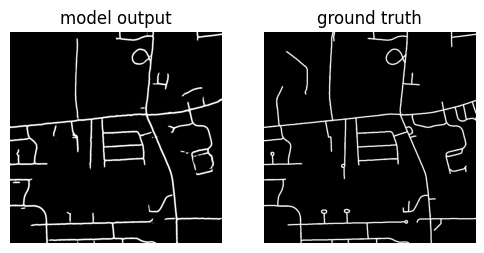

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:34<00:00,  1.01it/s]


epoch 8 | loss 0.18007 | average IoU for validation 55.20% | validation loss 0.4728 | learning rate 0.0001


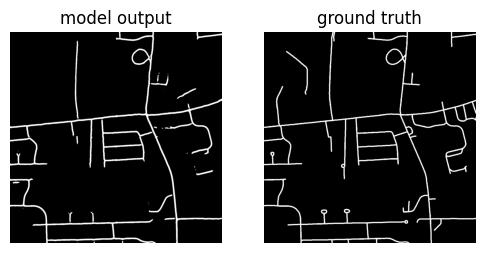

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:41<00:00,  1.02s/it]


epoch 9 | loss 0.17824 | average IoU for validation 53.04% | validation loss 0.4934 | learning rate 0.0001


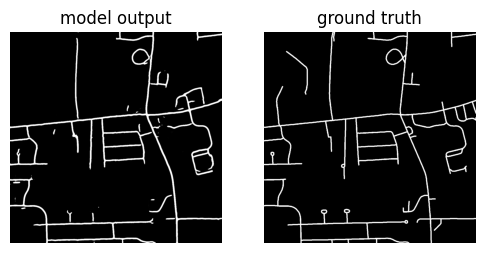

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:36<00:00,  1.00it/s]


epoch 10 | loss 0.17409 | average IoU for validation 51.71% | validation loss 0.5068 | learning rate 0.0001


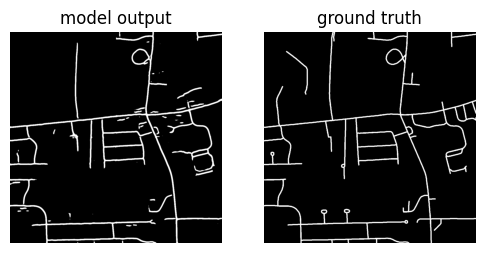

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [05:19<00:00,  1.15s/it]


epoch 11 | loss 0.17505 | average IoU for validation 53.84% | validation loss 0.4816 | learning rate 0.0001


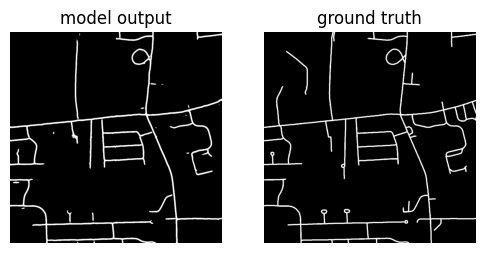

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:25<00:00,  1.04it/s]


epoch 12 | loss 0.17836 | average IoU for validation 52.13% | validation loss 0.4952 | learning rate 0.0001


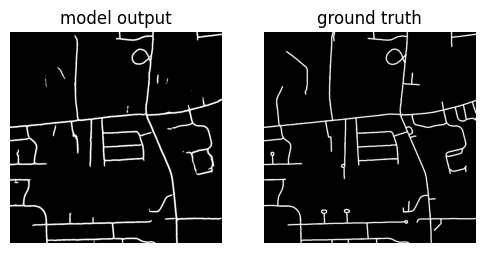

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:24<00:00,  1.05it/s]


epoch 13 | loss 0.17310 | average IoU for validation 54.12% | validation loss 0.4768 | learning rate 0.0001


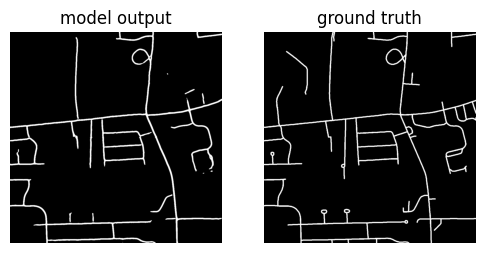

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 14 | loss 0.17268 | average IoU for validation 54.54% | validation loss 0.4726 | learning rate 0.0001


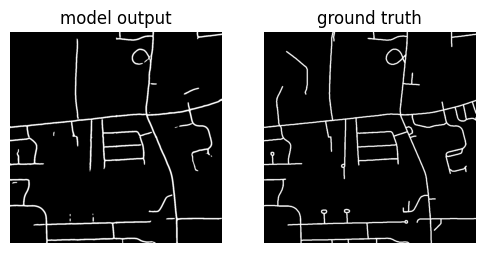

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:29<00:00,  1.03it/s]


epoch 15 | loss 0.17168 | average IoU for validation 54.16% | validation loss 0.4765 | learning rate 0.0001


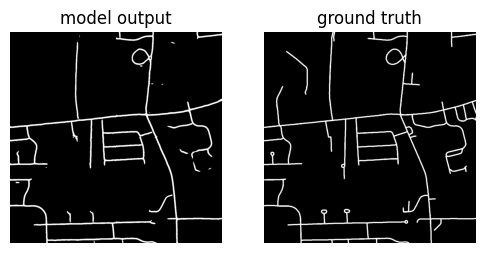

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 16 | loss 0.17201 | average IoU for validation 55.78% | validation loss 0.4609 | learning rate 0.0001


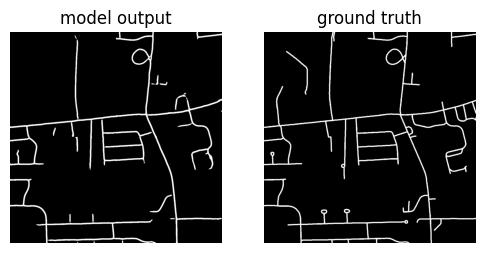

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 17 | loss 0.16916 | average IoU for validation 53.76% | validation loss 0.4777 | learning rate 0.0001


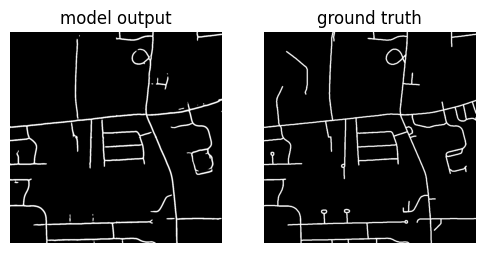

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:41<00:00,  1.02s/it]


epoch 18 | loss 0.16902 | average IoU for validation 55.32% | validation loss 0.4647 | learning rate 0.0001


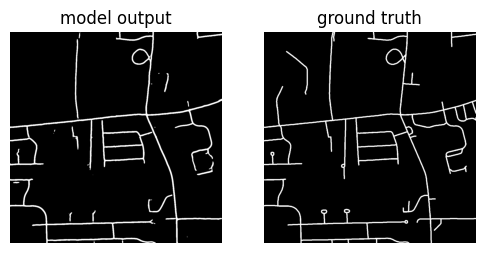

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:25<00:00,  1.04it/s]


epoch 19 | loss 0.16823 | average IoU for validation 56.04% | validation loss 0.4589 | learning rate 0.0001


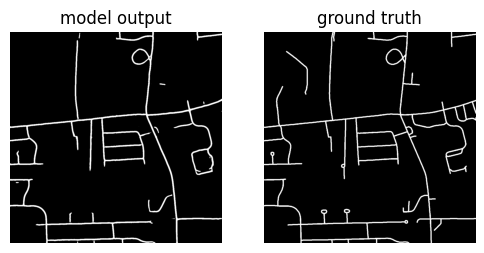

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 20 | loss 0.16974 | average IoU for validation 55.88% | validation loss 0.4601 | learning rate 0.0001


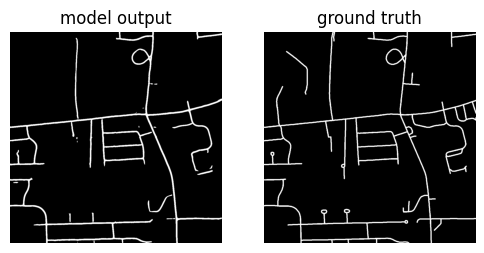

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 21 | loss 0.16814 | average IoU for validation 55.06% | validation loss 0.4661 | learning rate 0.0001


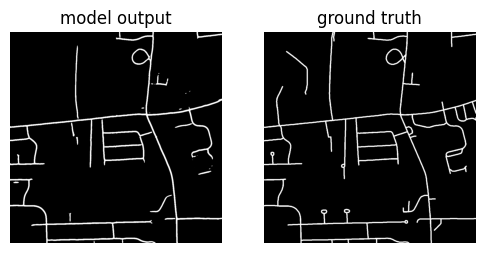

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 22 | loss 0.16930 | average IoU for validation 56.80% | validation loss 0.4515 | learning rate 0.0001


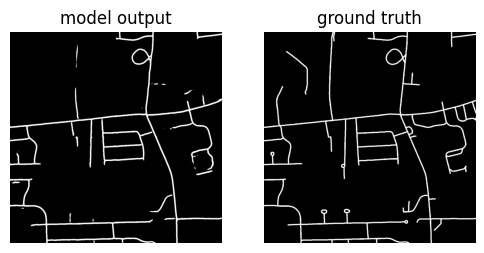

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:28<00:00,  1.03it/s]


epoch 23 | loss 0.16559 | average IoU for validation 56.40% | validation loss 0.4571 | learning rate 0.0001


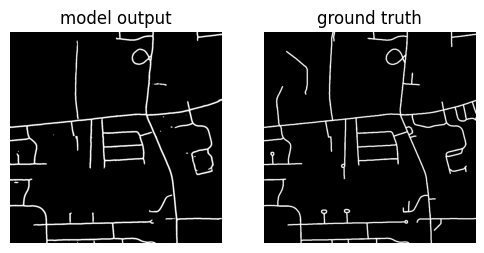

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 24 | loss 0.16504 | average IoU for validation 56.23% | validation loss 0.4556 | learning rate 0.0001


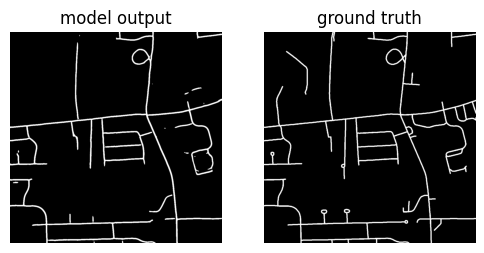

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:22<00:00,  1.06it/s]


epoch 25 | loss 0.16839 | average IoU for validation 56.59% | validation loss 0.4545 | learning rate 0.0001


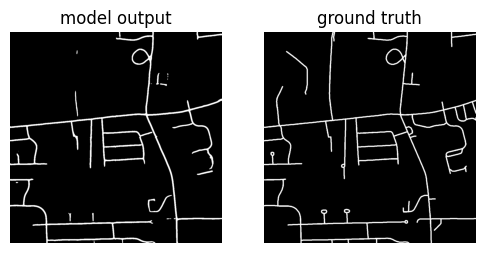

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 26 | loss 0.16918 | average IoU for validation 55.73% | validation loss 0.4603 | learning rate 0.0001


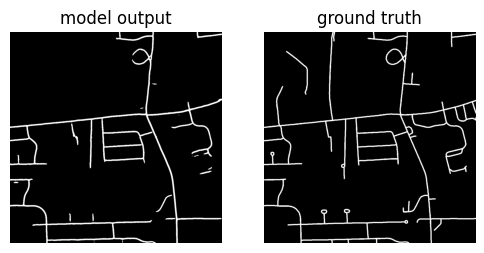

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:25<00:00,  1.04it/s]


epoch 27 | loss 0.16354 | average IoU for validation 57.57% | validation loss 0.4448 | learning rate 0.0001


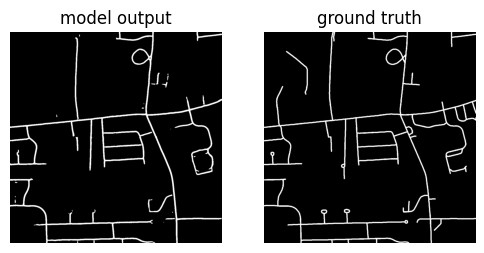

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 28 | loss 0.16649 | average IoU for validation 57.34% | validation loss 0.4462 | learning rate 0.0001


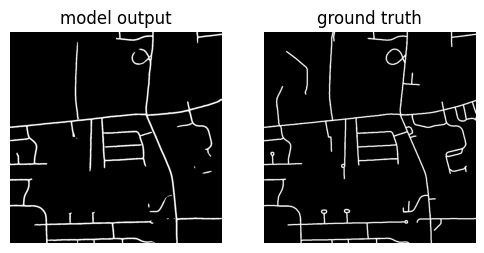

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:35<00:00,  1.00it/s]


epoch 29 | loss 0.16413 | average IoU for validation 55.66% | validation loss 0.4598 | learning rate 0.0001


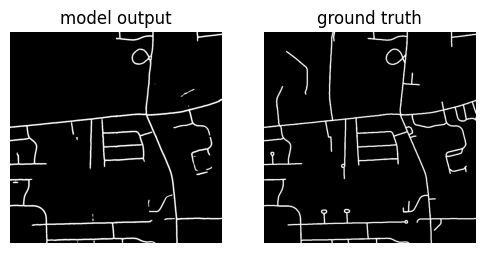

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:29<00:00,  1.03it/s]


epoch 30 | loss 0.16580 | average IoU for validation 57.19% | validation loss 0.4478 | learning rate 0.0001


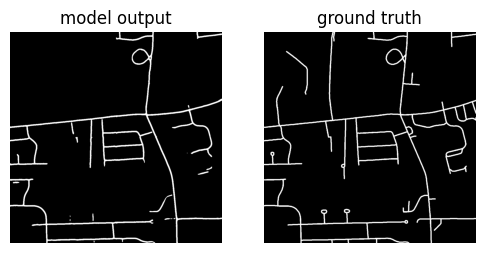

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:38<00:00,  1.01s/it]


epoch 31 | loss 0.16297 | average IoU for validation 56.91% | validation loss 0.4499 | learning rate 0.0001


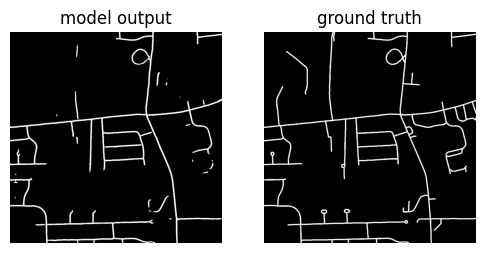

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:30<00:00,  1.02it/s]


epoch 32 | loss 0.16104 | average IoU for validation 57.06% | validation loss 0.4482 | learning rate 0.0001


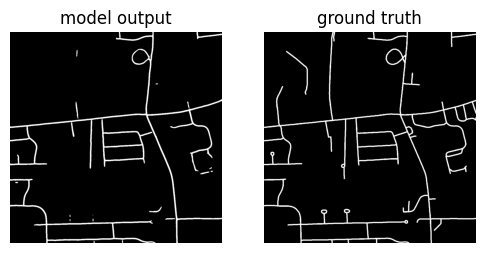

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:24<00:00,  1.05it/s]


epoch 33 | loss 0.16521 | average IoU for validation 55.42% | validation loss 0.4661 | learning rate 0.0001


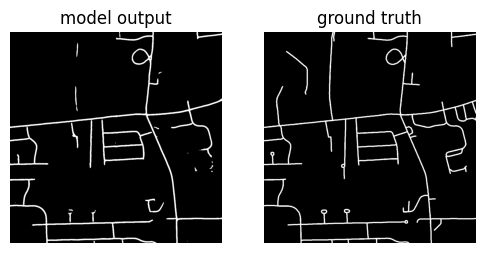

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:25<00:00,  1.04it/s]


epoch 34 | loss 0.16757 | average IoU for validation 55.70% | validation loss 0.4594 | learning rate 0.0001


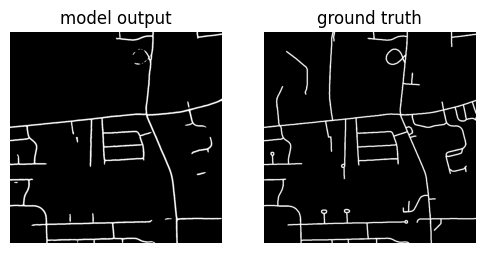

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:38<00:00,  1.01s/it]


epoch 35 | loss 0.16317 | average IoU for validation 57.70% | validation loss 0.4438 | learning rate 0.0001


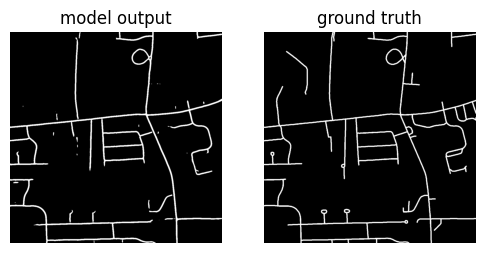

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:21<00:00,  1.06it/s]


epoch 36 | loss 0.16387 | average IoU for validation 56.82% | validation loss 0.4501 | learning rate 0.0001


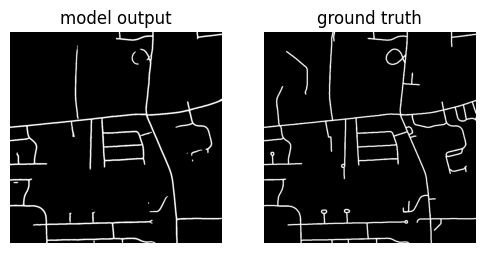

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:24<00:00,  1.05it/s]


epoch 37 | loss 0.15926 | average IoU for validation 57.94% | validation loss 0.4411 | learning rate 1e-05


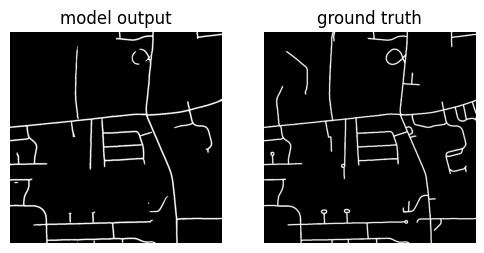

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:48<00:00,  1.04s/it]


epoch 38 | loss 0.16123 | average IoU for validation 58.16% | validation loss 0.4389 | learning rate 1e-05


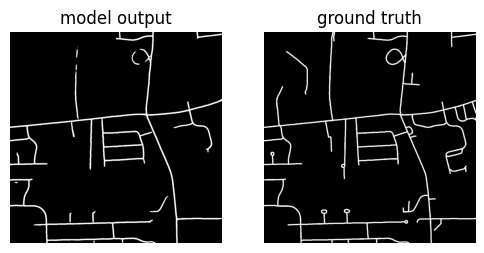

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:55<00:00,  1.07s/it]


epoch 39 | loss 0.15764 | average IoU for validation 58.58% | validation loss 0.4356 | learning rate 1e-05


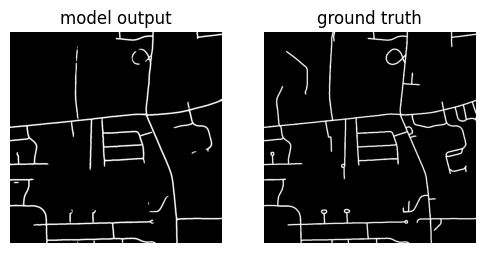

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:20<00:00,  1.06it/s]


epoch 40 | loss 0.15586 | average IoU for validation 58.56% | validation loss 0.4362 | learning rate 1e-05


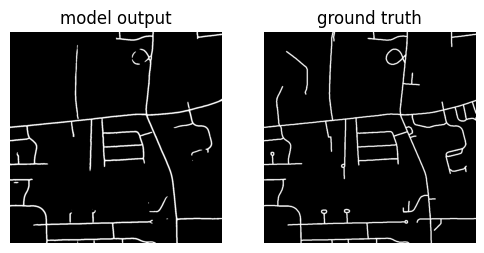

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:22<00:00,  1.06it/s]


epoch 41 | loss 0.15839 | average IoU for validation 58.72% | validation loss 0.4350 | learning rate 1e-05


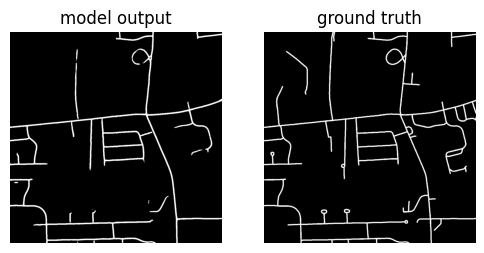

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 42 | loss 0.16086 | average IoU for validation 59.37% | validation loss 0.4294 | learning rate 1e-05


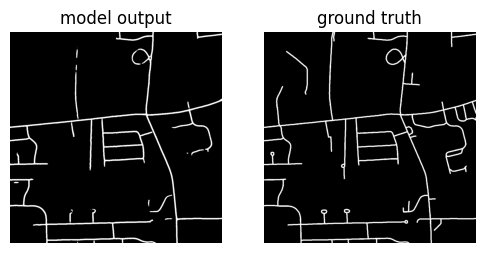

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:29<00:00,  1.03it/s]


epoch 43 | loss 0.15658 | average IoU for validation 58.57% | validation loss 0.4359 | learning rate 1e-05


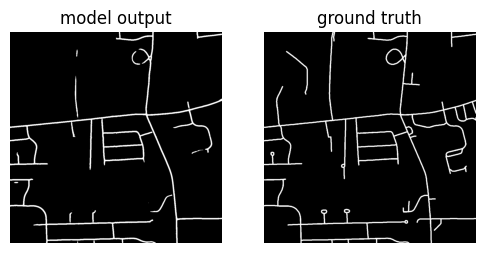

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 44 | loss 0.15862 | average IoU for validation 58.09% | validation loss 0.4392 | learning rate 1e-05


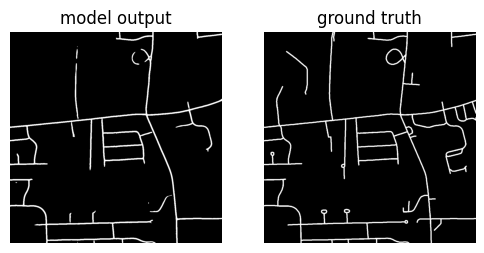

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:20<00:00,  1.06it/s]


epoch 45 | loss 0.15732 | average IoU for validation 58.37% | validation loss 0.4371 | learning rate 1.0000000000000002e-06


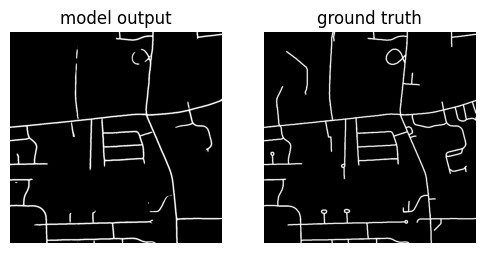

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:35<00:00,  1.01it/s]


epoch 46 | loss 0.15955 | average IoU for validation 58.68% | validation loss 0.4347 | learning rate 1.0000000000000002e-06


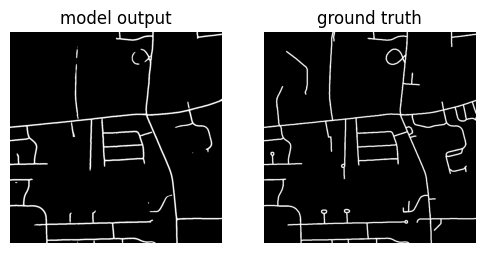

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:27<00:00,  1.04it/s]


epoch 47 | loss 0.15636 | average IoU for validation 58.79% | validation loss 0.4339 | learning rate 1.0000000000000002e-06


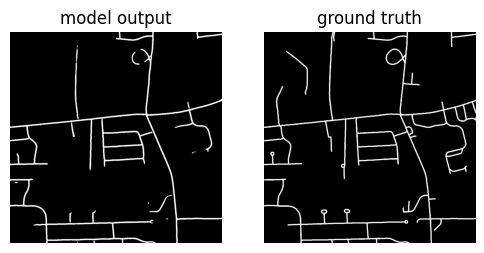

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:29<00:00,  1.03it/s]


epoch 48 | loss 0.15469 | average IoU for validation 58.91% | validation loss 0.4330 | learning rate 1.0000000000000002e-06


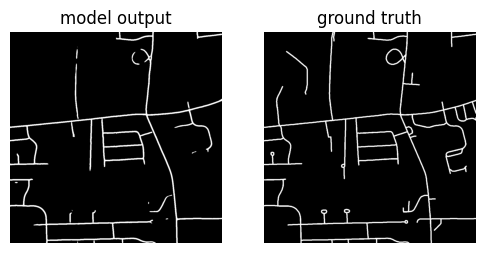

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:18<00:00,  1.07it/s]


epoch 49 | loss 0.15720 | average IoU for validation 58.57% | validation loss 0.4356 | learning rate 1.0000000000000002e-06


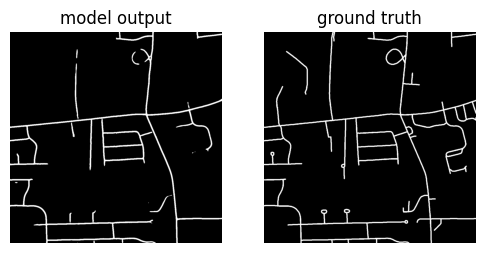

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:36<00:00,  1.00it/s]


epoch 50 | loss 0.15982 | average IoU for validation 59.08% | validation loss 0.4316 | learning rate 1.0000000000000002e-06


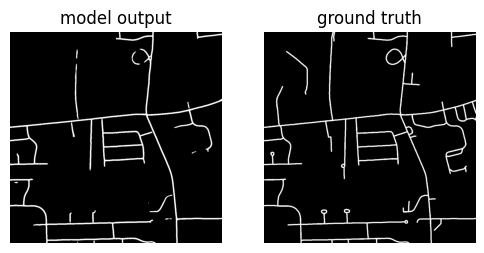

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 51 | loss 0.15532 | average IoU for validation 58.76% | validation loss 0.4341 | learning rate 1.0000000000000002e-06


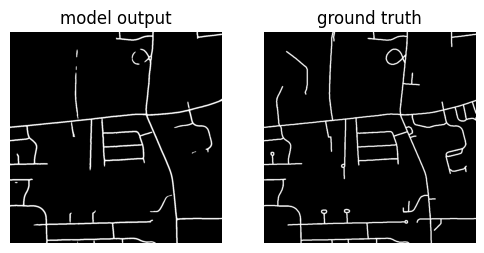

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:21<00:00,  1.06it/s]


epoch 52 | loss 0.15756 | average IoU for validation 58.90% | validation loss 0.4330 | learning rate 1.0000000000000002e-06


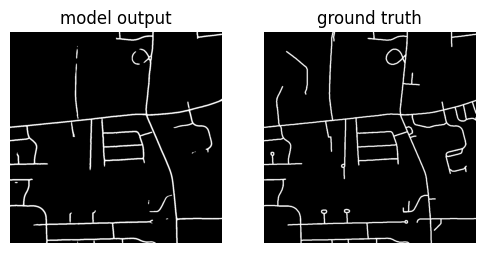

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:27<00:00,  1.03it/s]


epoch 53 | loss 0.15671 | average IoU for validation 58.60% | validation loss 0.4352 | learning rate 1.0000000000000002e-07


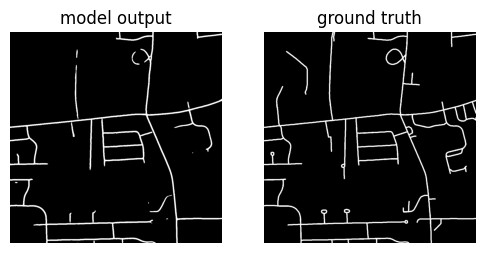

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:27<00:00,  1.03it/s]


epoch 54 | loss 0.15926 | average IoU for validation 58.67% | validation loss 0.4347 | learning rate 1.0000000000000002e-07


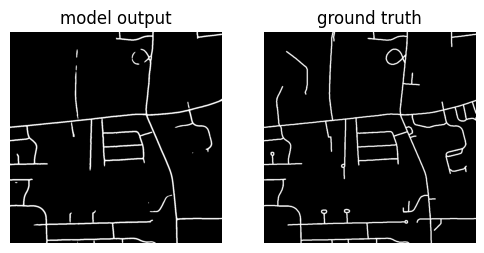

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:36<00:00,  1.00it/s]


epoch 55 | loss 0.15610 | average IoU for validation 58.86% | validation loss 0.4334 | learning rate 1.0000000000000002e-07


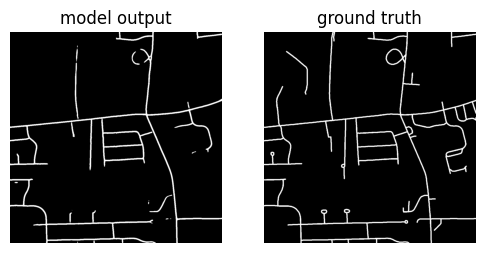

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:29<00:00,  1.03it/s]


epoch 56 | loss 0.15448 | average IoU for validation 58.83% | validation loss 0.4336 | learning rate 1.0000000000000002e-07


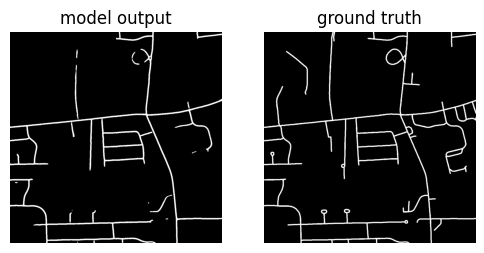

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:21<00:00,  1.06it/s]


epoch 57 | loss 0.15698 | average IoU for validation 58.58% | validation loss 0.4356 | learning rate 1.0000000000000002e-07


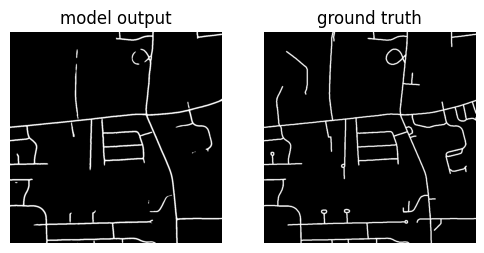

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:25<00:00,  1.04it/s]


epoch 58 | loss 0.15962 | average IoU for validation 58.96% | validation loss 0.4326 | learning rate 1.0000000000000002e-07


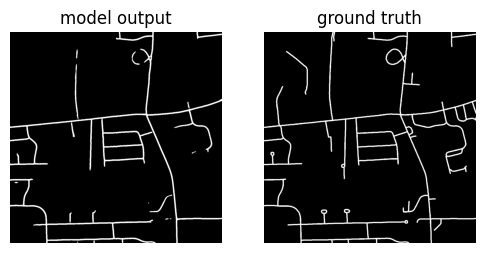

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 59 | loss 0.15512 | average IoU for validation 58.82% | validation loss 0.4337 | learning rate 1.0000000000000002e-07


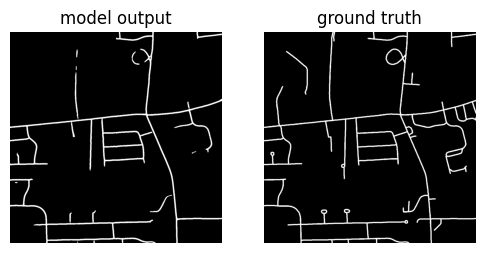

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:22<00:00,  1.05it/s]


epoch 60 | loss 0.15740 | average IoU for validation 58.94% | validation loss 0.4327 | learning rate 1.0000000000000002e-07


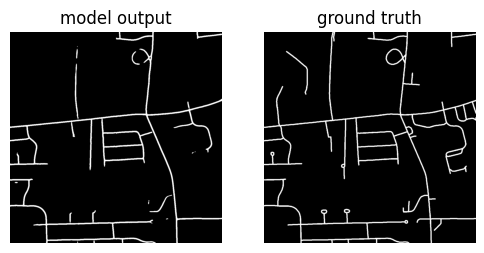

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:27<00:00,  1.04it/s]


epoch 61 | loss 0.15666 | average IoU for validation 58.63% | validation loss 0.4351 | learning rate 1.0000000000000004e-08


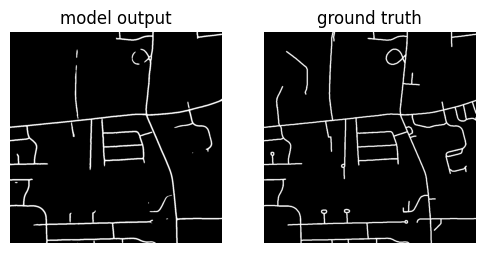

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:19<00:00,  1.07it/s]


epoch 62 | loss 0.15923 | average IoU for validation 58.66% | validation loss 0.4347 | learning rate 1.0000000000000004e-08


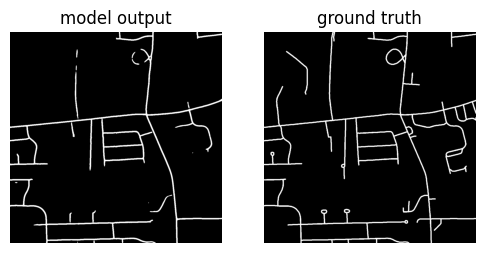

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 63 | loss 0.15607 | average IoU for validation 58.86% | validation loss 0.4333 | learning rate 1.0000000000000004e-08


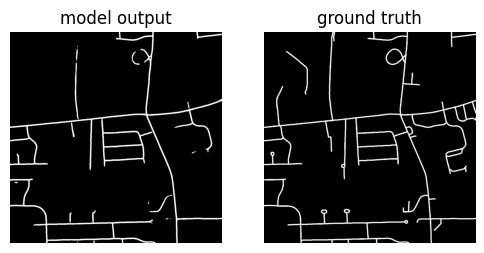

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:49<00:00,  1.05s/it]


epoch 64 | loss 0.15446 | average IoU for validation 58.81% | validation loss 0.4337 | learning rate 1.0000000000000004e-08


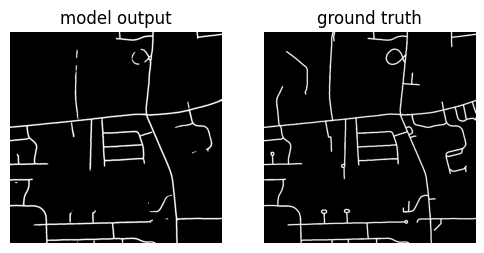

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:37<00:00,  1.00s/it]


epoch 65 | loss 0.15695 | average IoU for validation 58.57% | validation loss 0.4356 | learning rate 1.0000000000000004e-08


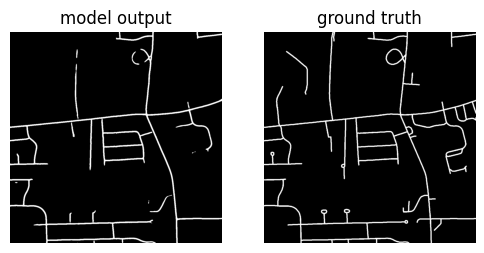

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:19<00:00,  1.07it/s]


epoch 66 | loss 0.15960 | average IoU for validation 58.95% | validation loss 0.4327 | learning rate 1.0000000000000004e-08


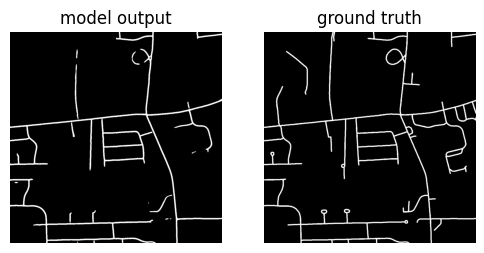

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:23<00:00,  1.05it/s]


epoch 67 | loss 0.15510 | average IoU for validation 58.82% | validation loss 0.4337 | learning rate 1.0000000000000004e-08


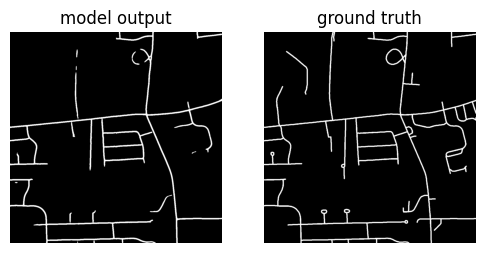

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:28<00:00,  1.03it/s]


epoch 68 | loss 0.15739 | average IoU for validation 58.95% | validation loss 0.4326 | learning rate 1.0000000000000004e-08


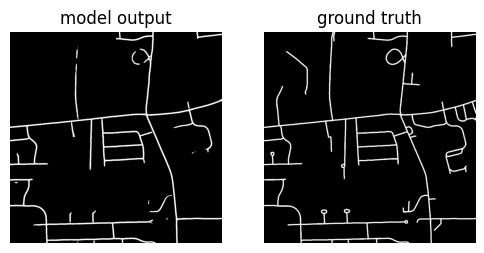

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:34<00:00,  1.01it/s]


epoch 69 | loss 0.15665 | average IoU for validation 58.63% | validation loss 0.4350 | learning rate 1.0000000000000004e-08


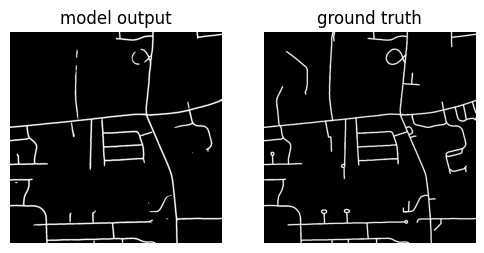

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:28<00:00,  1.03it/s]


epoch 70 | loss 0.15922 | average IoU for validation 58.67% | validation loss 0.4347 | learning rate 1.0000000000000004e-08


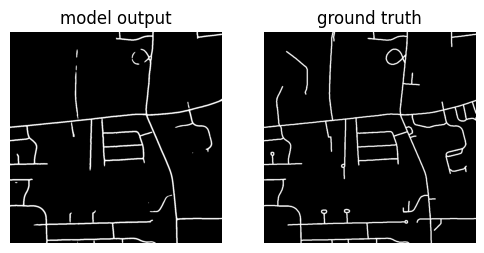

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:28<00:00,  1.03it/s]


epoch 71 | loss 0.15607 | average IoU for validation 58.87% | validation loss 0.4333 | learning rate 1.0000000000000004e-08


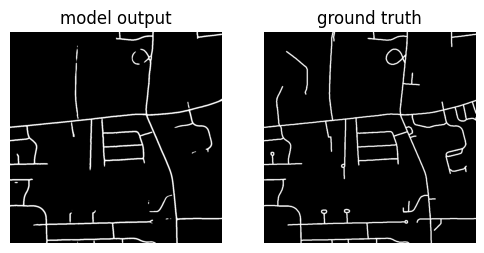

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:34<00:00,  1.01it/s]


epoch 72 | loss 0.15446 | average IoU for validation 58.82% | validation loss 0.4336 | learning rate 1.0000000000000004e-08


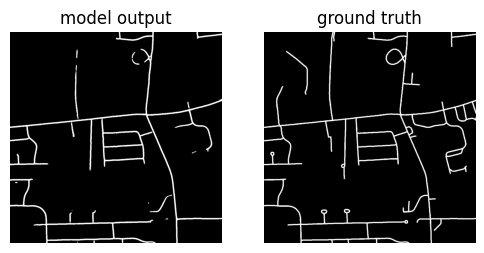

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:19<00:00,  1.07it/s]


epoch 73 | loss 0.15695 | average IoU for validation 58.58% | validation loss 0.4356 | learning rate 1.0000000000000004e-08


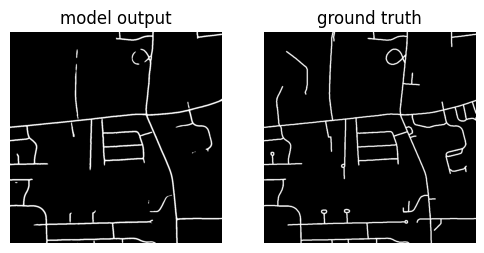

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:32<00:00,  1.01it/s]


epoch 74 | loss 0.15960 | average IoU for validation 58.95% | validation loss 0.4327 | learning rate 1.0000000000000004e-08


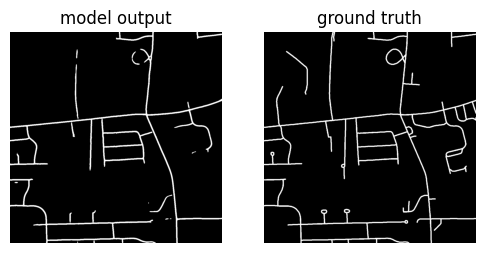

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:27<00:00,  1.03it/s]


epoch 75 | loss 0.15510 | average IoU for validation 58.83% | validation loss 0.4337 | learning rate 1.0000000000000004e-08


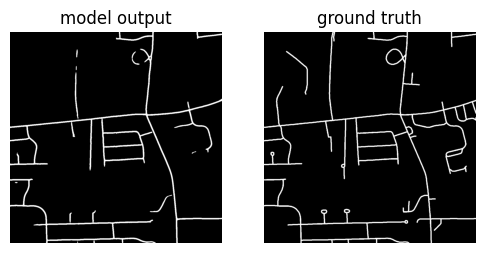

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:24<00:00,  1.05it/s]


epoch 76 | loss 0.15739 | average IoU for validation 58.95% | validation loss 0.4326 | learning rate 1.0000000000000004e-08


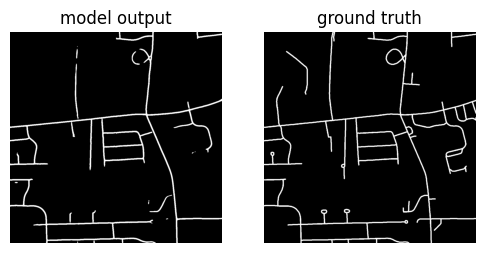

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:39<00:00,  1.01s/it]


epoch 77 | loss 0.15665 | average IoU for validation 58.64% | validation loss 0.4350 | learning rate 1.0000000000000004e-08


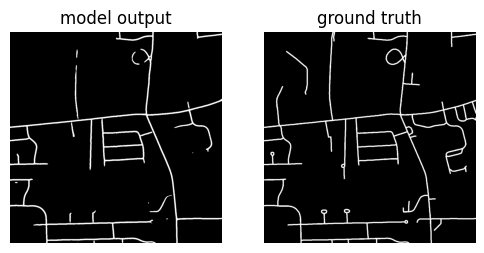

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:27<00:00,  1.04it/s]


epoch 78 | loss 0.15922 | average IoU for validation 58.68% | validation loss 0.4347 | learning rate 1.0000000000000004e-08


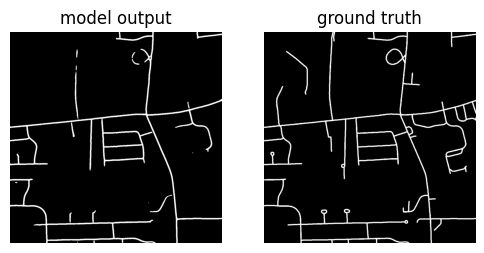

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:24<00:00,  1.05it/s]


epoch 79 | loss 0.15607 | average IoU for validation 58.87% | validation loss 0.4332 | learning rate 1.0000000000000004e-08


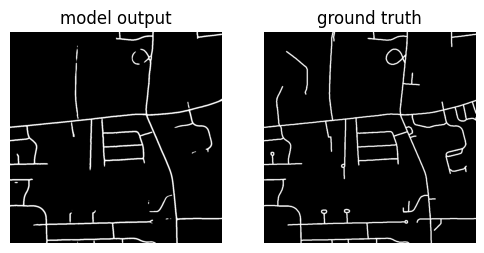

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:17<00:00,  1.08it/s]


epoch 80 | loss 0.15445 | average IoU for validation 58.83% | validation loss 0.4336 | learning rate 1.0000000000000004e-08


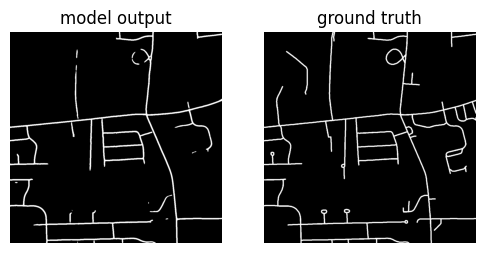

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:15<00:00,  1.09it/s]


epoch 81 | loss 0.15695 | average IoU for validation 58.58% | validation loss 0.4356 | learning rate 1.0000000000000004e-08


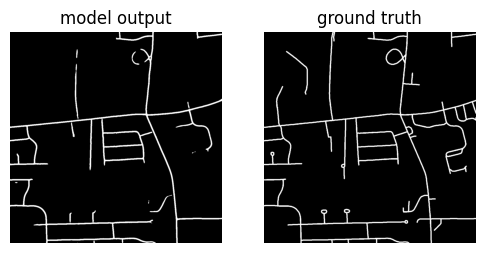

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:17<00:00,  1.07it/s]


epoch 82 | loss 0.15959 | average IoU for validation 58.95% | validation loss 0.4327 | learning rate 1.0000000000000004e-08


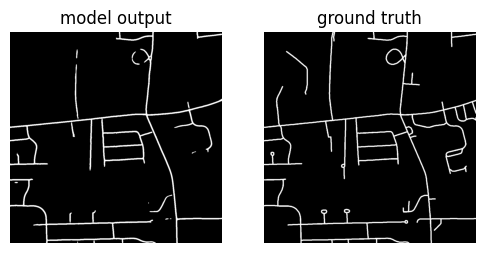

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:16<00:00,  1.08it/s]


epoch 83 | loss 0.15510 | average IoU for validation 58.83% | validation loss 0.4337 | learning rate 1.0000000000000004e-08


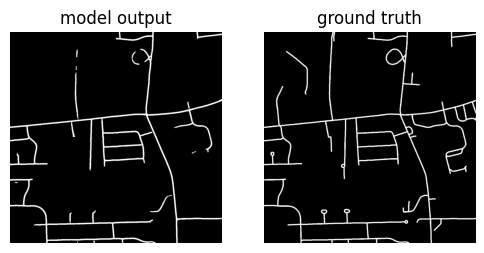

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:15<00:00,  1.09it/s]


epoch 84 | loss 0.15739 | average IoU for validation 58.96% | validation loss 0.4326 | learning rate 1.0000000000000004e-08


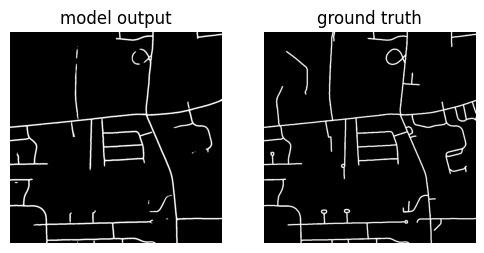

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:13<00:00,  1.09it/s]


epoch 85 | loss 0.15664 | average IoU for validation 58.64% | validation loss 0.4350 | learning rate 1.0000000000000004e-08


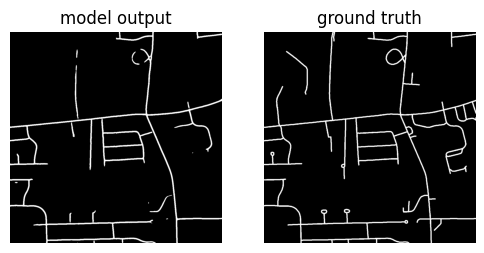

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:17<00:00,  1.08it/s]


epoch 86 | loss 0.15921 | average IoU for validation 58.68% | validation loss 0.4346 | learning rate 1.0000000000000004e-08


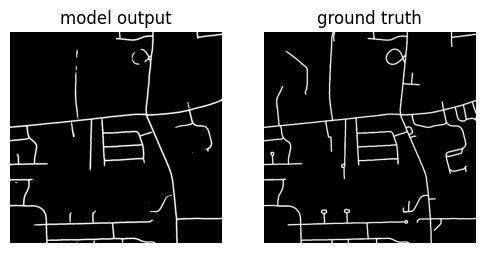

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:30<00:00,  1.03it/s]


epoch 87 | loss 0.15606 | average IoU for validation 58.88% | validation loss 0.4332 | learning rate 1.0000000000000004e-08


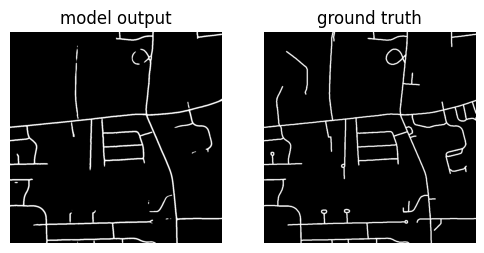

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:11<00:00,  1.10it/s]


epoch 88 | loss 0.15445 | average IoU for validation 58.83% | validation loss 0.4336 | learning rate 1.0000000000000004e-08


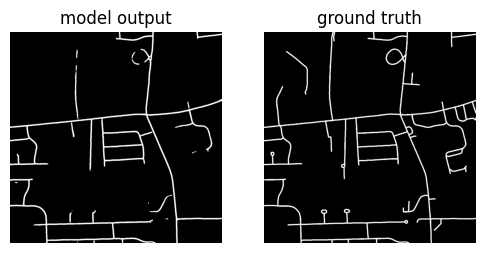

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:14<00:00,  1.09it/s]


epoch 89 | loss 0.15695 | average IoU for validation 58.59% | validation loss 0.4355 | learning rate 1.0000000000000004e-08


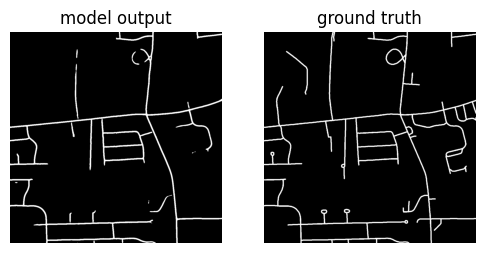

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 90 | loss 0.15959 | average IoU for validation 58.96% | validation loss 0.4326 | learning rate 1.0000000000000004e-08


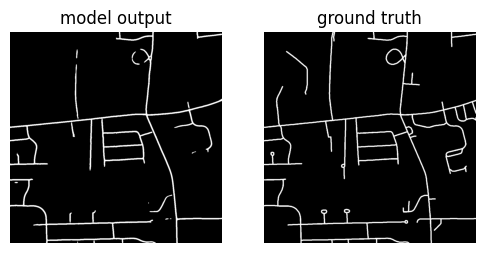

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:19<00:00,  1.07it/s]


epoch 91 | loss 0.15510 | average IoU for validation 58.83% | validation loss 0.4336 | learning rate 1.0000000000000004e-08


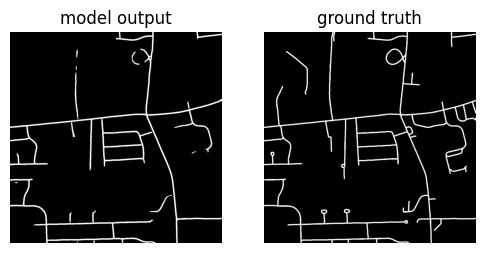

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:29<00:00,  1.03it/s]


epoch 92 | loss 0.15739 | average IoU for validation 58.96% | validation loss 0.4325 | learning rate 1.0000000000000004e-08


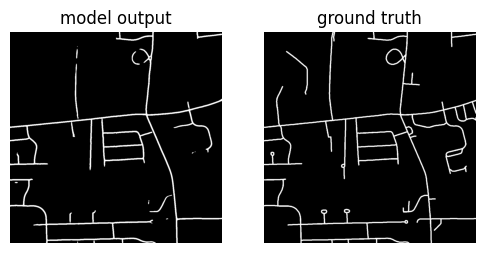

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:16<00:00,  1.08it/s]


epoch 93 | loss 0.15664 | average IoU for validation 58.64% | validation loss 0.4349 | learning rate 1.0000000000000004e-08


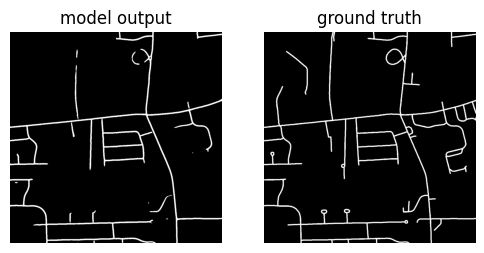

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:21<00:00,  1.06it/s]


epoch 94 | loss 0.15921 | average IoU for validation 58.69% | validation loss 0.4346 | learning rate 1.0000000000000004e-08


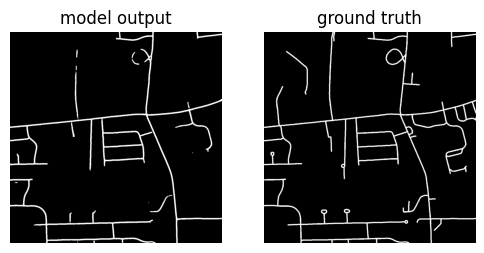

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:17<00:00,  1.08it/s]


epoch 95 | loss 0.15606 | average IoU for validation 58.88% | validation loss 0.4332 | learning rate 1.0000000000000004e-08


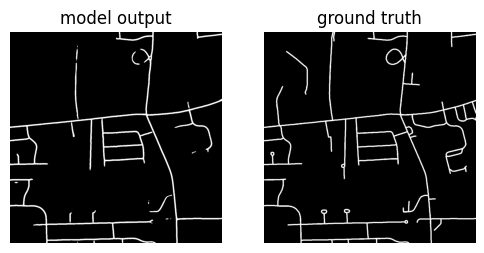

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:19<00:00,  1.07it/s]


epoch 96 | loss 0.15444 | average IoU for validation 58.83% | validation loss 0.4335 | learning rate 1.0000000000000004e-08


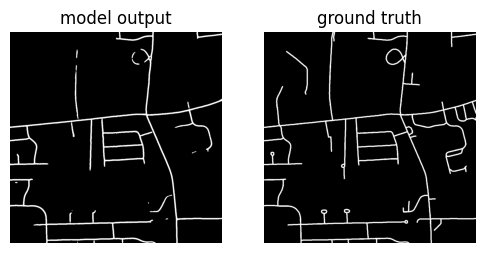

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:19<00:00,  1.07it/s]


epoch 97 | loss 0.15695 | average IoU for validation 58.59% | validation loss 0.4355 | learning rate 1.0000000000000004e-08


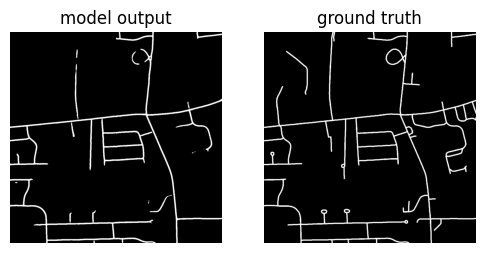

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:17<00:00,  1.08it/s]


epoch 98 | loss 0.15959 | average IoU for validation 58.96% | validation loss 0.4326 | learning rate 1.0000000000000004e-08


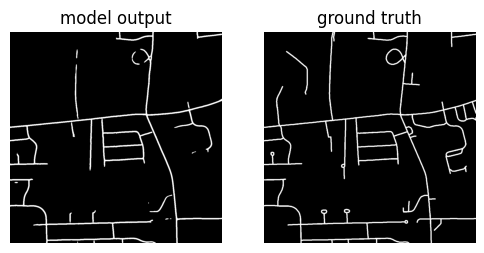

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:13<00:00,  1.09it/s]


epoch 99 | loss 0.15510 | average IoU for validation 58.84% | validation loss 0.4336 | learning rate 1.0000000000000004e-08


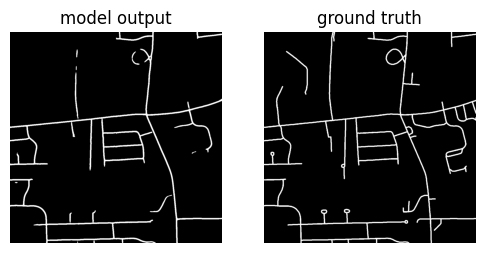

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:17<00:00,  1.08it/s]


epoch 100 | loss 0.15739 | average IoU for validation 58.96% | validation loss 0.4325 | learning rate 1.0000000000000004e-08


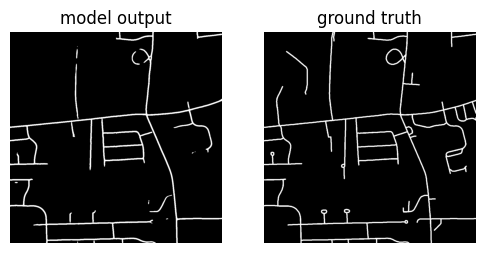

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:15<00:00,  1.08it/s]


epoch 101 | loss 0.15663 | average IoU for validation 58.65% | validation loss 0.4349 | learning rate 1.0000000000000004e-08


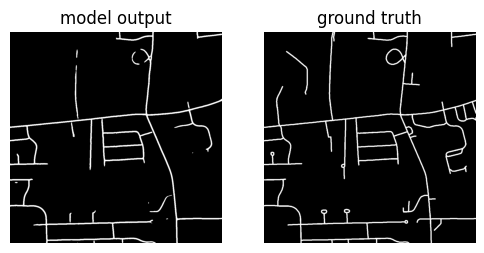

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:18<00:00,  1.07it/s]


epoch 102 | loss 0.15921 | average IoU for validation 58.69% | validation loss 0.4346 | learning rate 1.0000000000000004e-08


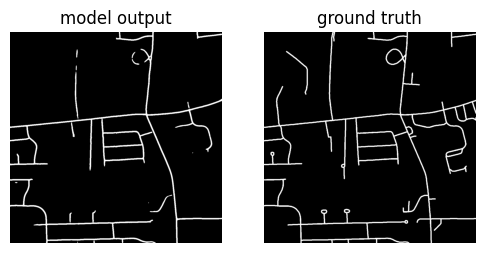

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:18<00:00,  1.07it/s]


epoch 103 | loss 0.15606 | average IoU for validation 58.88% | validation loss 0.4332 | learning rate 1.0000000000000004e-08


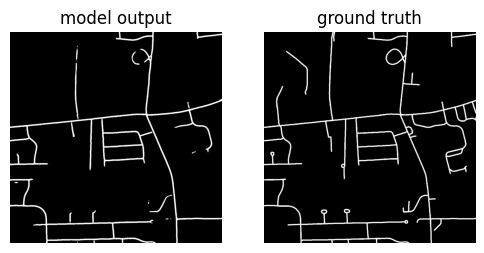

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:13<00:00,  1.09it/s]


epoch 104 | loss 0.15444 | average IoU for validation 58.84% | validation loss 0.4335 | learning rate 1.0000000000000004e-08


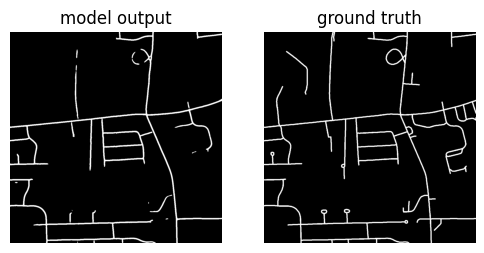

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:17<00:00,  1.08it/s]


epoch 105 | loss 0.15694 | average IoU for validation 58.60% | validation loss 0.4355 | learning rate 1.0000000000000004e-08


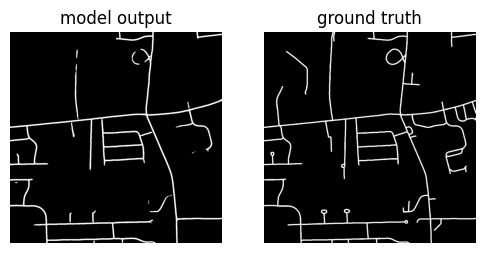

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:31<00:00,  1.02it/s]


epoch 106 | loss 0.15958 | average IoU for validation 58.96% | validation loss 0.4326 | learning rate 1.0000000000000004e-08


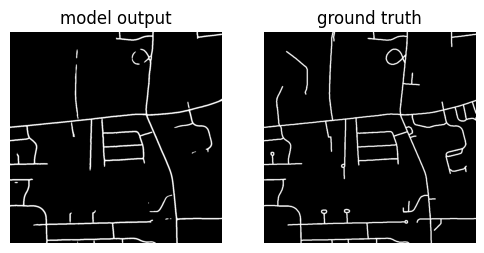

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:10<00:00,  1.11it/s]


epoch 107 | loss 0.15510 | average IoU for validation 58.84% | validation loss 0.4336 | learning rate 1.0000000000000004e-08


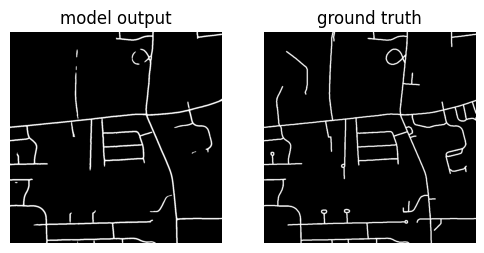

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:15<00:00,  1.09it/s]


epoch 108 | loss 0.15739 | average IoU for validation 58.96% | validation loss 0.4325 | learning rate 1.0000000000000004e-08


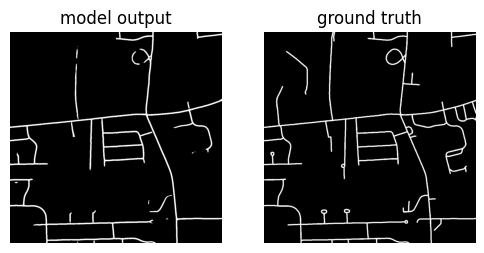

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:26<00:00,  1.04it/s]


epoch 109 | loss 0.15663 | average IoU for validation 58.65% | validation loss 0.4349 | learning rate 1.0000000000000004e-08


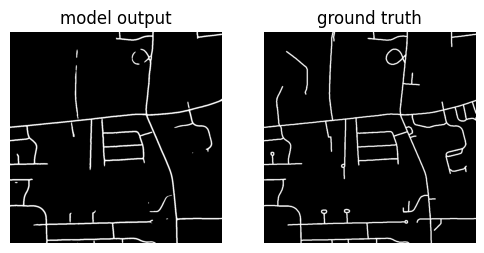

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:14<00:00,  1.09it/s]


epoch 110 | loss 0.15920 | average IoU for validation 58.69% | validation loss 0.4346 | learning rate 1.0000000000000004e-08


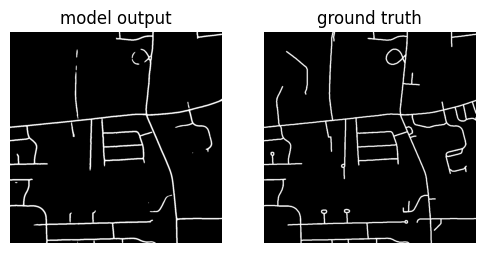

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:16<00:00,  1.08it/s]


epoch 111 | loss 0.15606 | average IoU for validation 58.89% | validation loss 0.4331 | learning rate 1.0000000000000004e-08


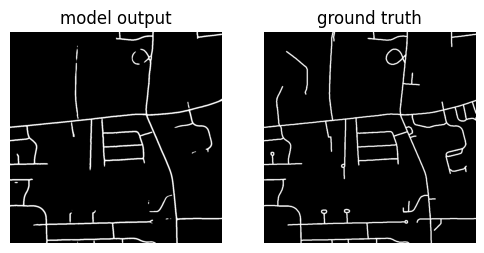

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:09<00:00,  1.11it/s]


epoch 112 | loss 0.15444 | average IoU for validation 58.84% | validation loss 0.4335 | learning rate 1.0000000000000004e-08


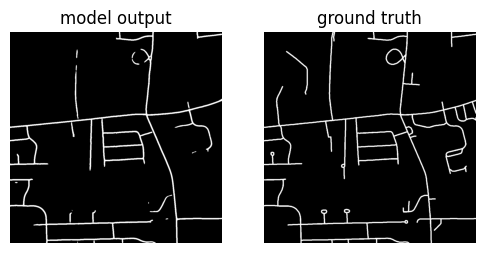

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:14<00:00,  1.09it/s]


epoch 113 | loss 0.15694 | average IoU for validation 58.60% | validation loss 0.4354 | learning rate 1.0000000000000004e-08


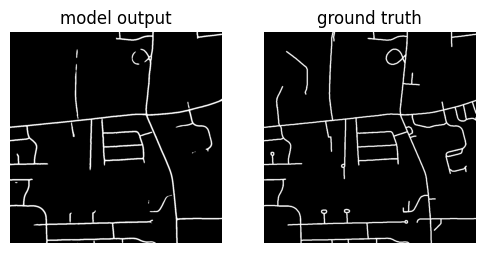

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:09<00:00,  1.11it/s]


epoch 114 | loss 0.15958 | average IoU for validation 58.96% | validation loss 0.4326 | learning rate 1.0000000000000004e-08


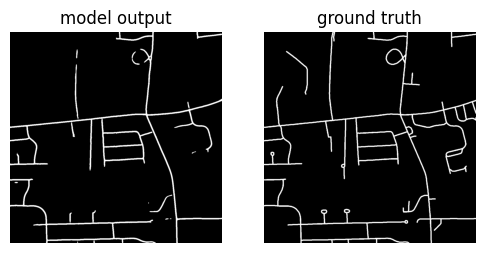

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:11<00:00,  1.10it/s]


epoch 115 | loss 0.15510 | average IoU for validation 58.84% | validation loss 0.4336 | learning rate 1.0000000000000004e-08


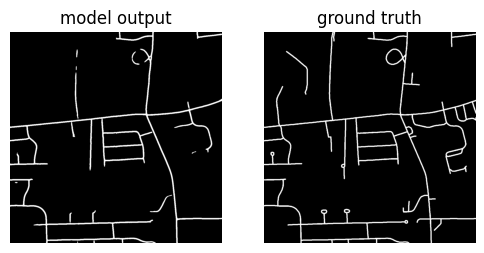

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:18<00:00,  1.07it/s]


epoch 116 | loss 0.15739 | average IoU for validation 58.96% | validation loss 0.4325 | learning rate 1.0000000000000004e-08


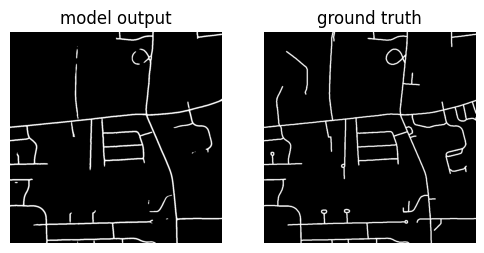

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:15<00:00,  1.08it/s]


epoch 117 | loss 0.15662 | average IoU for validation 58.65% | validation loss 0.4349 | learning rate 1.0000000000000004e-08


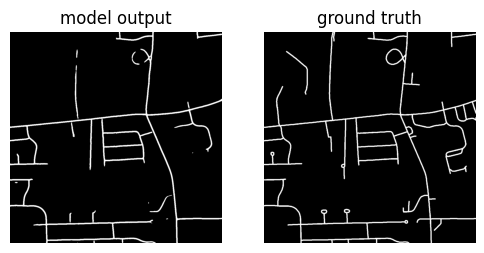

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:14<00:00,  1.09it/s]


epoch 118 | loss 0.15920 | average IoU for validation 58.69% | validation loss 0.4345 | learning rate 1.0000000000000004e-08


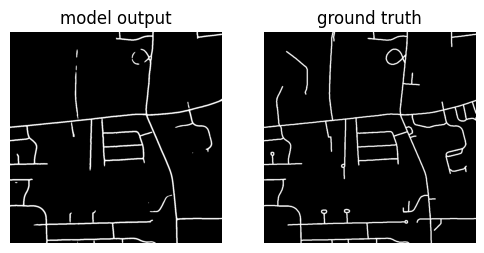

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:14<00:00,  1.09it/s]


epoch 119 | loss 0.15605 | average IoU for validation 58.89% | validation loss 0.4331 | learning rate 1.0000000000000004e-08


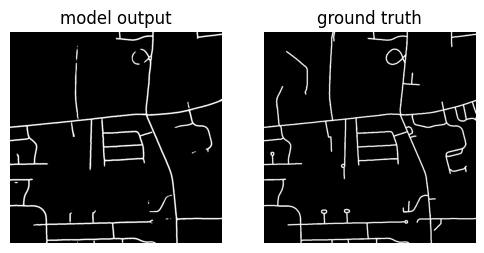

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:09<00:00,  1.11it/s]


epoch 120 | loss 0.15443 | average IoU for validation 58.84% | validation loss 0.4335 | learning rate 1.0000000000000004e-08


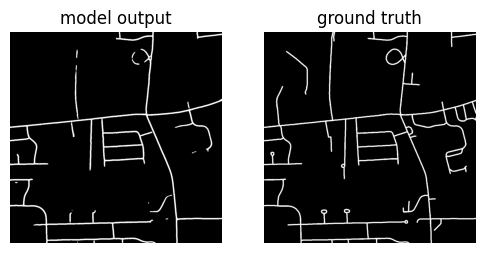

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:09<00:00,  1.11it/s]


epoch 121 | loss 0.15694 | average IoU for validation 58.60% | validation loss 0.4354 | learning rate 1.0000000000000004e-08


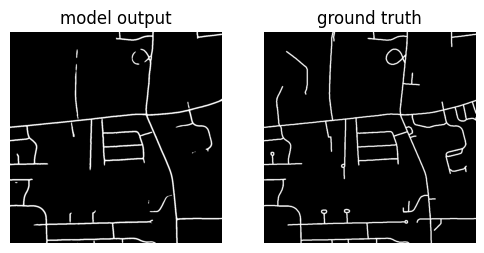

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:13<00:00,  1.09it/s]


epoch 122 | loss 0.15958 | average IoU for validation 58.97% | validation loss 0.4325 | learning rate 1.0000000000000004e-08


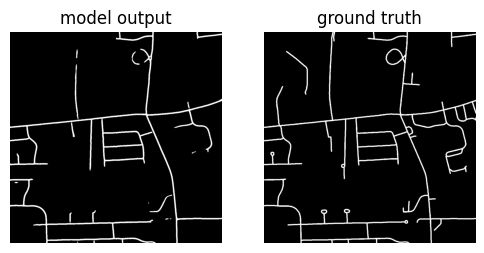

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:12<00:00,  1.10it/s]


epoch 123 | loss 0.15509 | average IoU for validation 58.84% | validation loss 0.4335 | learning rate 1.0000000000000004e-08


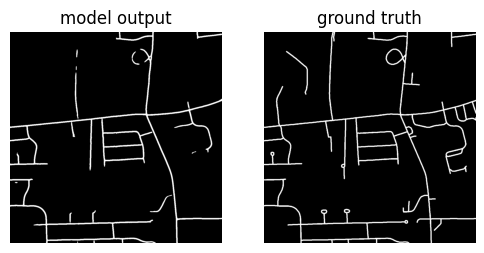

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:21<00:00,  1.06it/s]


epoch 124 | loss 0.15739 | average IoU for validation 58.97% | validation loss 0.4324 | learning rate 1.0000000000000004e-08


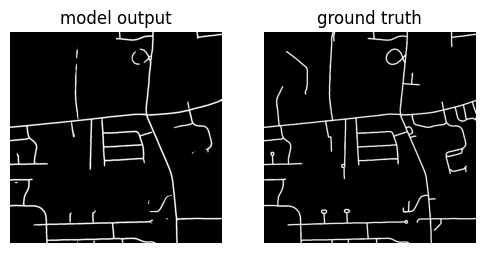

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:15<00:00,  1.08it/s]


epoch 125 | loss 0.15662 | average IoU for validation 58.66% | validation loss 0.4348 | learning rate 1.0000000000000004e-08


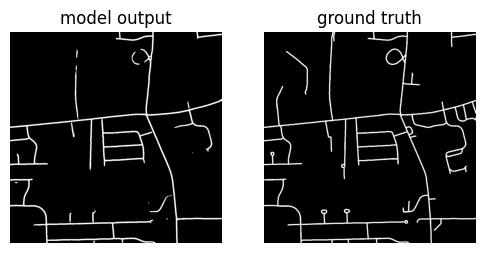

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:15<00:00,  1.08it/s]


epoch 126 | loss 0.15920 | average IoU for validation 58.69% | validation loss 0.4345 | learning rate 1.0000000000000004e-08


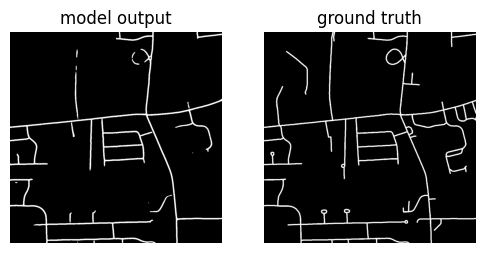

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:19<00:00,  1.07it/s]


epoch 127 | loss 0.15605 | average IoU for validation 58.89% | validation loss 0.4331 | learning rate 1.0000000000000004e-08


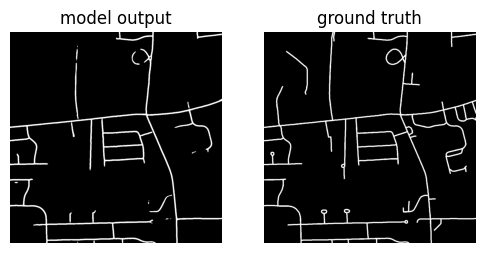

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:12<00:00,  1.10it/s]


epoch 128 | loss 0.15443 | average IoU for validation 58.84% | validation loss 0.4335 | learning rate 1.0000000000000004e-08


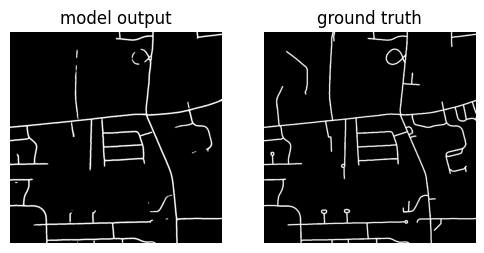

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:14<00:00,  1.09it/s]


epoch 129 | loss 0.15694 | average IoU for validation 58.61% | validation loss 0.4354 | learning rate 1.0000000000000004e-08


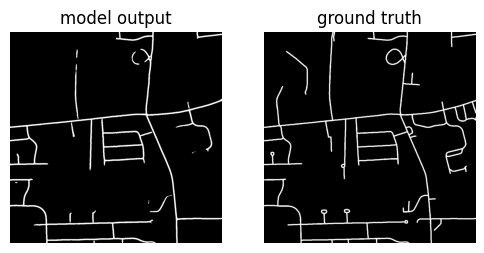

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:22<00:00,  1.06it/s]


epoch 130 | loss 0.15958 | average IoU for validation 58.97% | validation loss 0.4325 | learning rate 1.0000000000000004e-08


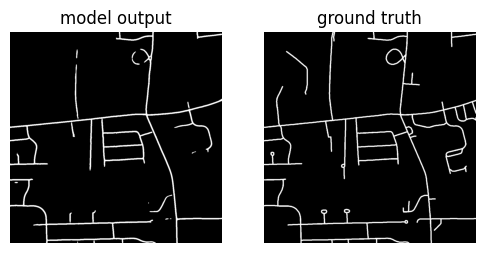

100%|████████████████████████████████████████████████████████████████████████████████| 277/277 [04:11<00:00,  1.10it/s]


epoch 131 | loss 0.15509 | average IoU for validation 58.85% | validation loss 0.4335 | learning rate 1.0000000000000004e-08


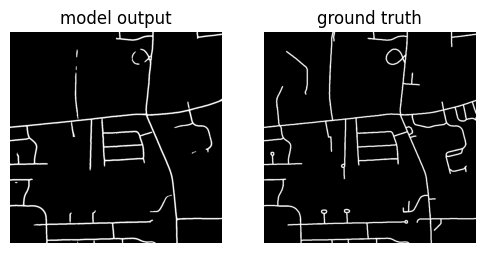

 66%|████████████████████████████████████████████████████▌                           | 182/277 [02:43<01:25,  1.11it/s]


KeyboardInterrupt: 

In [21]:
loss_graph = []
IoU_graph = []
lr_graph = []
for epoch in range(200):
    avg_loss = 0
    cnt = 0
    riba.train()
    for image_batch, label_batch in tqdm(train_loader):
        optim.zero_grad()
        image_batch = image_batch.cuda()
        label_batch = label_batch.cuda() 
        res = riba.forward(image_batch)
        loss = loss_function(res,label_batch)
        avg_loss += loss.item()
        loss.backward()
        optim.step()
        #scheduler.step()
        cnt += 1
        
    
    riba.eval()
    IoU_mean = 0
    cnt2 = 0
    val_loss = 0
    with torch.no_grad():
        for image_batch, label_batch in validation_loader:
            image_batch = image_batch.cuda()
            label_batch = label_batch.cuda()
            image_batch = OneToFour(image_batch)
            res = riba.forward(image_batch)
            res = FourToOne(res)
            val_loss += loss_function(res,label_batch).item()
            pred_binary = torch.where(res > 0.5, 1, 0)
            IoU_mean += jaccard_score(pred_binary.flatten().cpu().numpy(),label_batch.flatten().cpu().numpy(),average='binary',pos_label=1)
            cnt2 += 1
    
    val_loss /= cnt2
    IoU_mean /= cnt2
    avg_loss /= cnt * batch_size
    current_lr = scheduler.get_last_lr()[0]
    loss_graph.append(avg_loss)
    IoU_graph.append(IoU_mean)
    lr_graph.append(current_lr)
    scheduler.step(avg_loss)
    print(f'epoch {epoch} | loss {avg_loss:.5f} | average IoU for validation {(IoU_mean*100):.2f}% | validation loss {val_loss:.4f} | learning rate {current_lr}')
    show_pair(next(iter(validation_loader)))
    torch.save(riba.state_dict(),f'AttentionUNet_RE/epoch{epoch}.pt')
    #show_pair(next(iter(validation_loader)))

Text(0, 0.5, 'Loss')

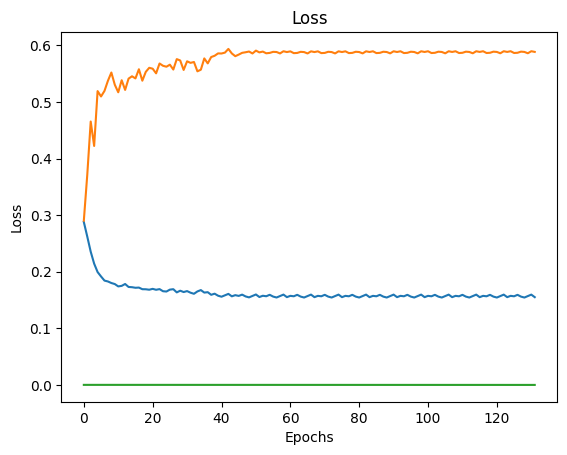

In [22]:
plt.figure()
plt.plot(loss_graph)
plt.plot(IoU_graph)
plt.plot(lr_graph)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [25]:
test_dataset = seg_dataset(
    image_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/test',
    label_root = 'C:/Users/Пк/.cache/kagglehub/datasets/balraj98/massachusetts-roads-dataset/versions/1/tiff/test_labels',
    image_transform = val_transform,
    label_transform = label_transform
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [29]:
riba = AttentionUNet()
riba.load_state_dict(torch.load('AttentionUNet_RE/epoch131.pt', weights_only=True))
IoU_mean = 0
cnt2 = 0
riba.eval()
with torch.no_grad():
    for image_batch, label_batch in tqdm(test_loader):
        #image_batch = image_batch.cuda()
        #label_batch = label_batch.cuda()
        image_batch = OneToFour(image_batch)
        res = riba.forward(image_batch)
        res = FourToOne(res)
        pred_binary = torch.where(res > 0.5, 1, 0)
        IoU_mean += jaccard_score(pred_binary.flatten().cpu().numpy(),label_batch.flatten().cpu().numpy(),average='binary',pos_label=1)
        cnt2 += 1
IoU_mean /= cnt2
print(f'IoU for test {IoU_mean}')

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [05:29<00:00,  6.72s/it]

IoU for test 0.6093327718316194
